# Feature Engineering

In [19]:
import sys
import pandas as pd
sys.path.append("../")
import warnings
warnings.filterwarnings("ignore")
from utils.engineering import anova_test, saving_dataset, Plots
from utils.visualizations import Visualization

# Data

In [20]:
df = pd.read_csv("./Data/clean_payments_final")
print(f"Shape: {df.shape}")
df.head()

Shape: (77414, 17)


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,INADIMPLENTE
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,2013-08-22,Nordeste,0,Serviços,YAHOO,PEQUENO,Nordeste,252109.0,99.0,0
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,2013-08-22,Nordeste,0,Serviços,YAHOO,PEQUENO,Nordeste,252109.0,99.0,0
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,2013-08-22,Nordeste,0,Serviços,YAHOO,PEQUENO,Nordeste,252109.0,99.0,0
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,2013-08-22,Nordeste,0,Serviços,YAHOO,PEQUENO,Nordeste,252109.0,99.0,1
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,2013-08-22,Nordeste,0,Serviços,YAHOO,PEQUENO,Nordeste,252109.0,99.0,0


In [21]:
df["SAFRA_REF"] = pd.to_datetime(df["SAFRA_REF"])
df["DATA_EMISSAO_DOCUMENTO"] = pd.to_datetime(df["DATA_EMISSAO_DOCUMENTO"])
df["DATA_VENCIMENTO"] = pd.to_datetime(df["DATA_VENCIMENTO"])
df["DATA_CADASTRO"] = pd.to_datetime(df["DATA_CADASTRO"])

# Creating new features

## Extracting year and month from datetime columns based on the EDA results

In [22]:
# Extract year and month from either `SAFRA_REF` or `DATA_EMISSAO_DOCUMENTO`
df["year"] = df["SAFRA_REF"].dt.year
df["month"] = df["SAFRA_REF"].dt.month

In [23]:
# Extract month from `DATA_VENCIMENTO`
df["month_vencimento"] = df["DATA_VENCIMENTO"].dt.month

In [24]:
# Extract year and month from `DATA_CADASTRO`
df["year_cadastro"] = df["DATA_CADASTRO"].dt.year
df["month_cadastro"] = df["DATA_CADASTRO"].dt.month

## Engineering new features that might be useful
- `loan_age`: Calculates how long it has been since the loan was issued, based on the difference between `DATA_EMISSAO_DOCUMENTO` and `SAFRA_REF`
- `days_until_due`: Computes the number of days remaining until the loan is due by subtracting `SAFRA_REF` from `DATA_VENCIMENTO`
- `days_since_registration`: Calculates the difference from client registration to loan issuance date by subtracting `DATA_CADASTRO` from `DATA_EMISSAO_DOCUMENTO`

In [25]:
# Create new features based on the datetime features available
df["loan_age"] = (df["SAFRA_REF"] - df["DATA_EMISSAO_DOCUMENTO"]).dt.days
df["days_until_due"] = (df["DATA_VENCIMENTO"] - df["SAFRA_REF"]).dt.days
df["days_since_registration"] = (df["DATA_EMISSAO_DOCUMENTO"] - df["DATA_CADASTRO"]).dt.days

# Testing the new features

In [26]:
new_features = ["year", "month", "month_vencimento", "year_cadastro", "month_cadastro", "loan_age", "days_until_due", "days_since_registration"]
anova_test(df, "INADIMPLENTE", new_features)

,Feature,p-value
0,year,4.813338e-01
1,month,5.757020e-10
2,month_vencimento,2.608840e-39
3,year_cadastro,2.477774e-20
4,month_cadastro,6.531992e-21
5,loan_age,1.551531e-11
6,days_until_due,3.679907e-150
7,days_since_registration,1.140138e-23


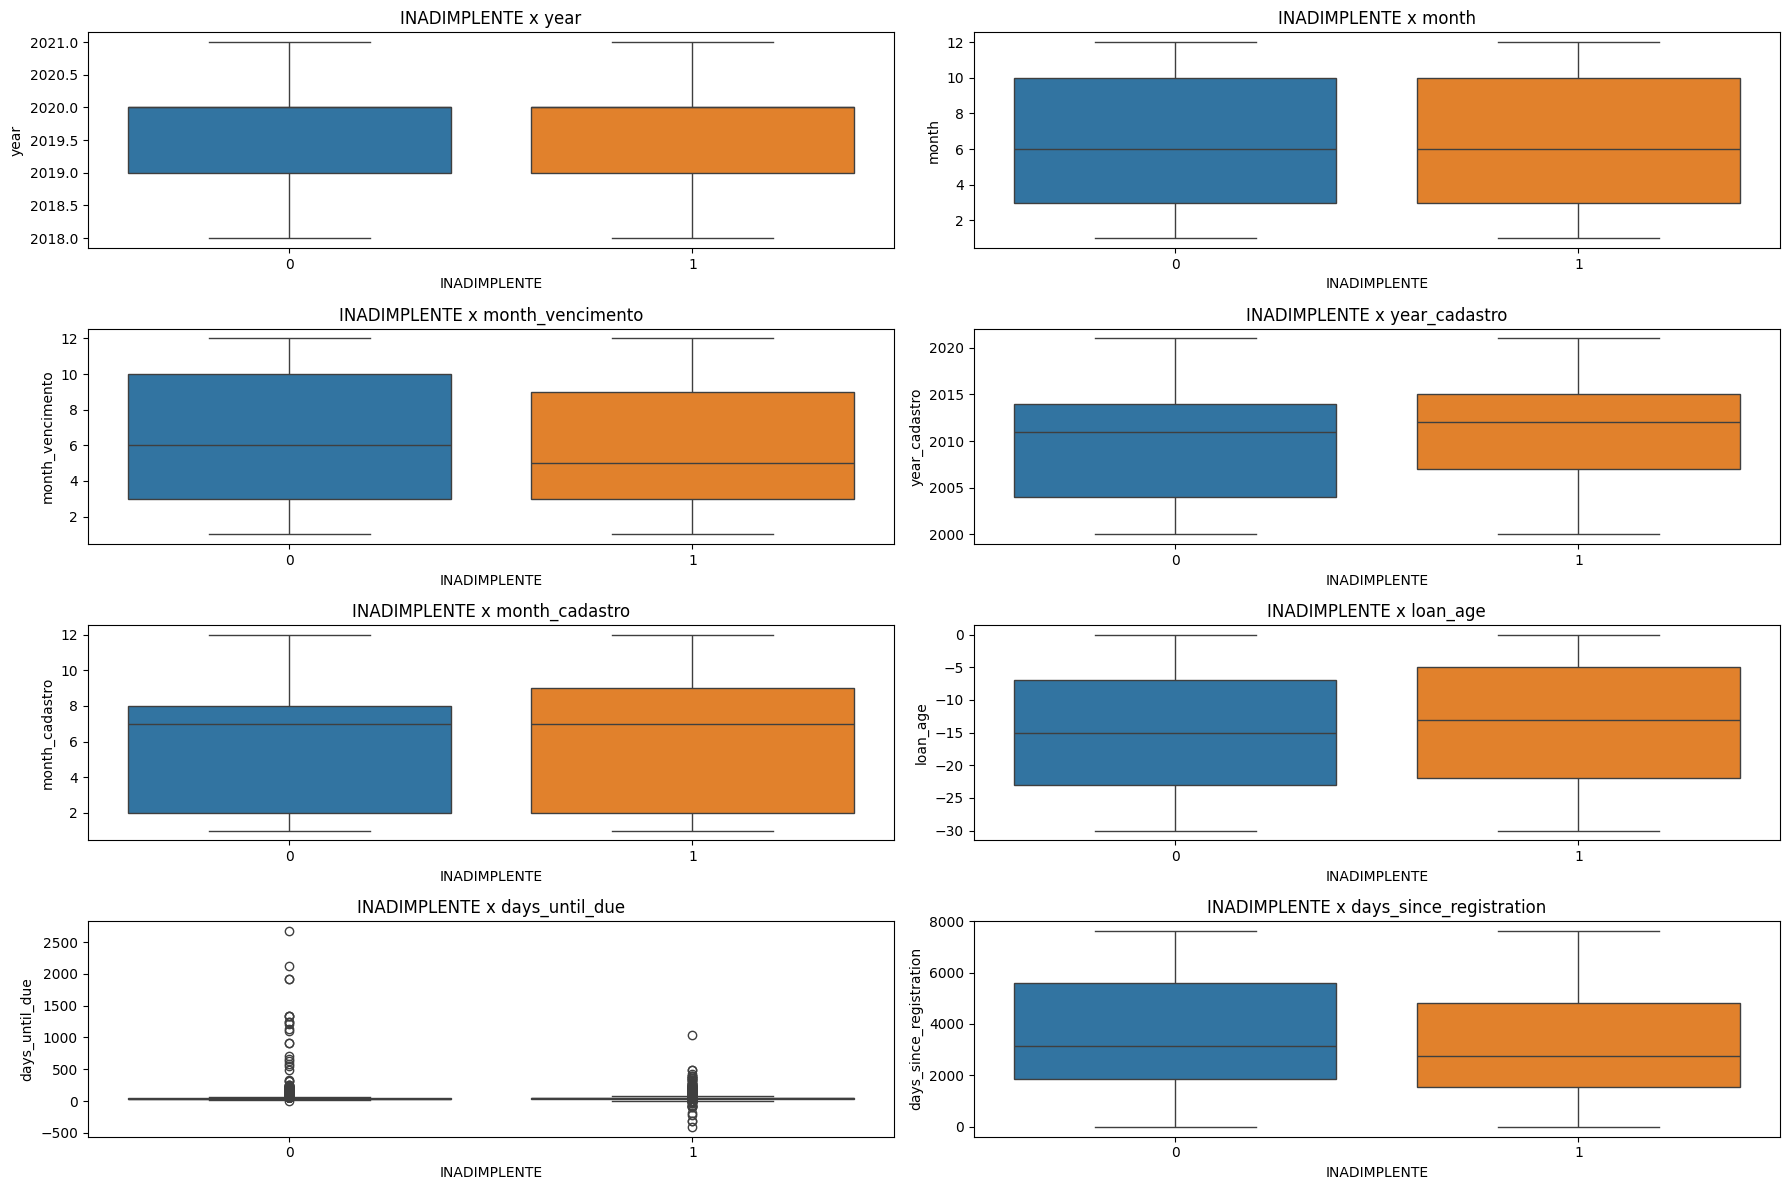

In [27]:
visualizer = Visualization(df)
visualizer.num_features_vs_target(4, 2, "INADIMPLENTE", new_features, "boxplot")

### Observations:
- Only the column `year` wasn't considered significant by the **ANOVA** test
- To see any kind of practical relation with the target feature, the boxplot analysis from the **EDA** was used
- `year`, `month`, `year_cadastro` and `month_cadastro` all have the same boxplot regarding the target, showing no practical relevance
- `month_vencimento`, `loan_age` and `days_since_registration` have similar boxplots, but the medians are different
- `days_until_due` shows a clear difference between the classes of the target variable
### Impact:
- The columns `year`, `month`, `year_cadastro` and `month_cadastro` can be dropped, since they have no practical relevance, despite three of them being significant in the **ANOVA** test
- `month_vencimento`, `loan_age` and `days_since_registration` can be used in a correlation heatmap to check for any kind of collinearity between features

## With the new columns tested, we can drop all features that won't be used from this point going forward

In [28]:
df = df.drop(columns=["ID_CLIENTE", "SAFRA_REF", "DATA_EMISSAO_DOCUMENTO", "DATA_PAGAMENTO", "DATA_VENCIMENTO",
                       "DATA_CADASTRO", "FLAG_PF", "year", "month", "year_cadastro", "month_cadastro"])

## Correlation Matrix

In [29]:
plotter = Plots(df)

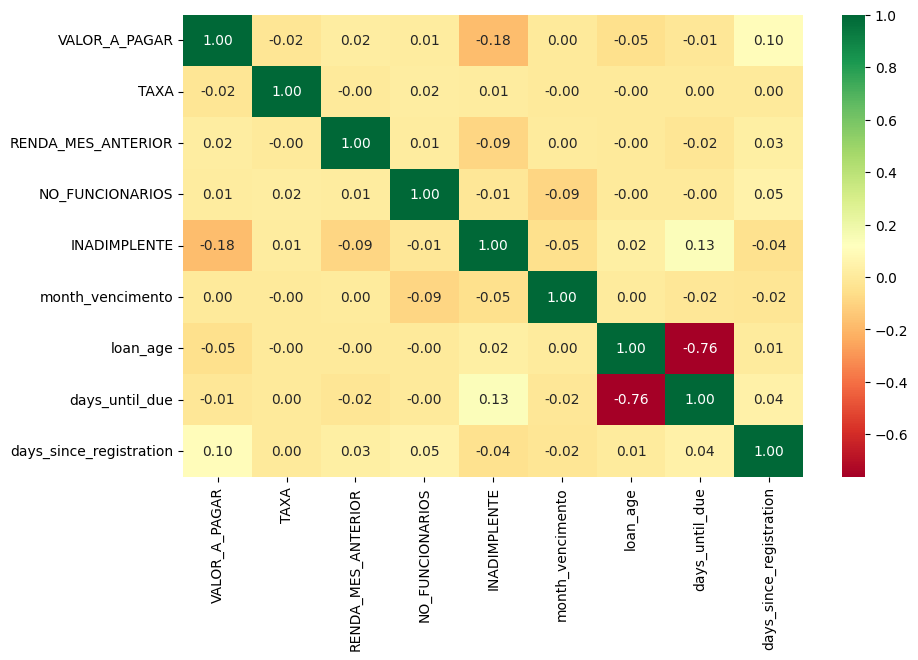

In [30]:
plotter.plot_corr("spearman", figsize=(10, 6))

### Observations:
- The **Spearman** method is used to make sure the correlation is robust against the outliers
- `VALOR_A_PAGAR` and `days_until_due` were the only features to show any kind of correlation with the target
- `days_until_due` and `loan_age` are strongly correlated
### Impact:
- Since two of the new features are strongly correlated, `loan_age` can be removed, since it didn't show a correlation with the target like `days_until_due` did

In [31]:
df = df.drop(columns=["loan_age"])

# Features Distributions
### The numerical features, except for `TAXA`, which has a discrete set of values, are not normally distributed. Since scaling techniques and certain models tend to perform better with normally distributed data, we will explore different transformation methods to see which works best for each column. `TAXA` and `month_vencimento` will be excluded from this analysis due to their categorical nature and limited set of specific values

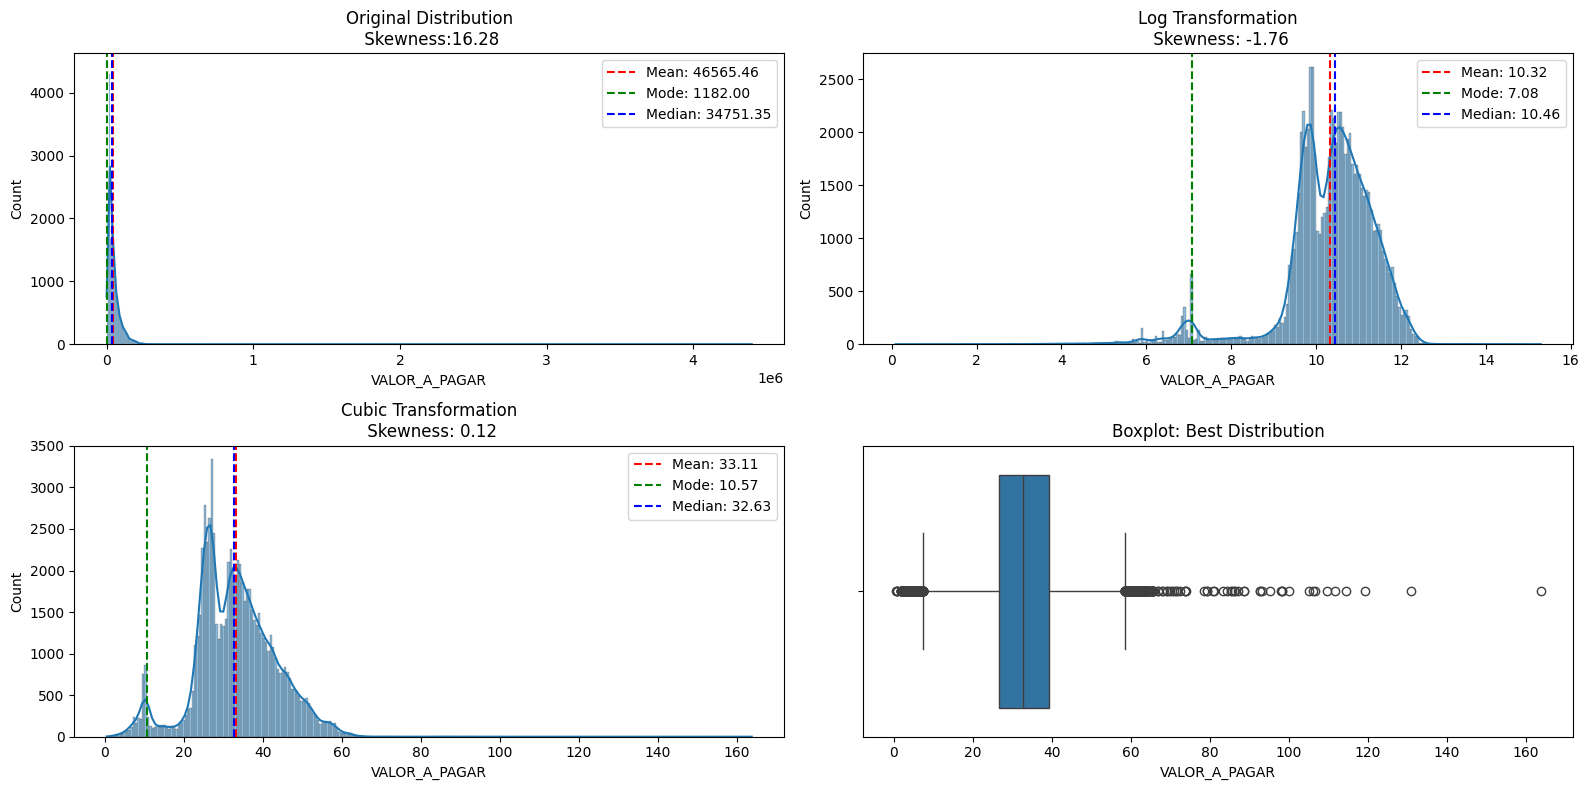

In [32]:
plotter.plot_transformed_distributions("VALOR_A_PAGAR")

### For `VALOR_A_PAGAR`, the **Cubic** transformation is the best one, and there are still outliers

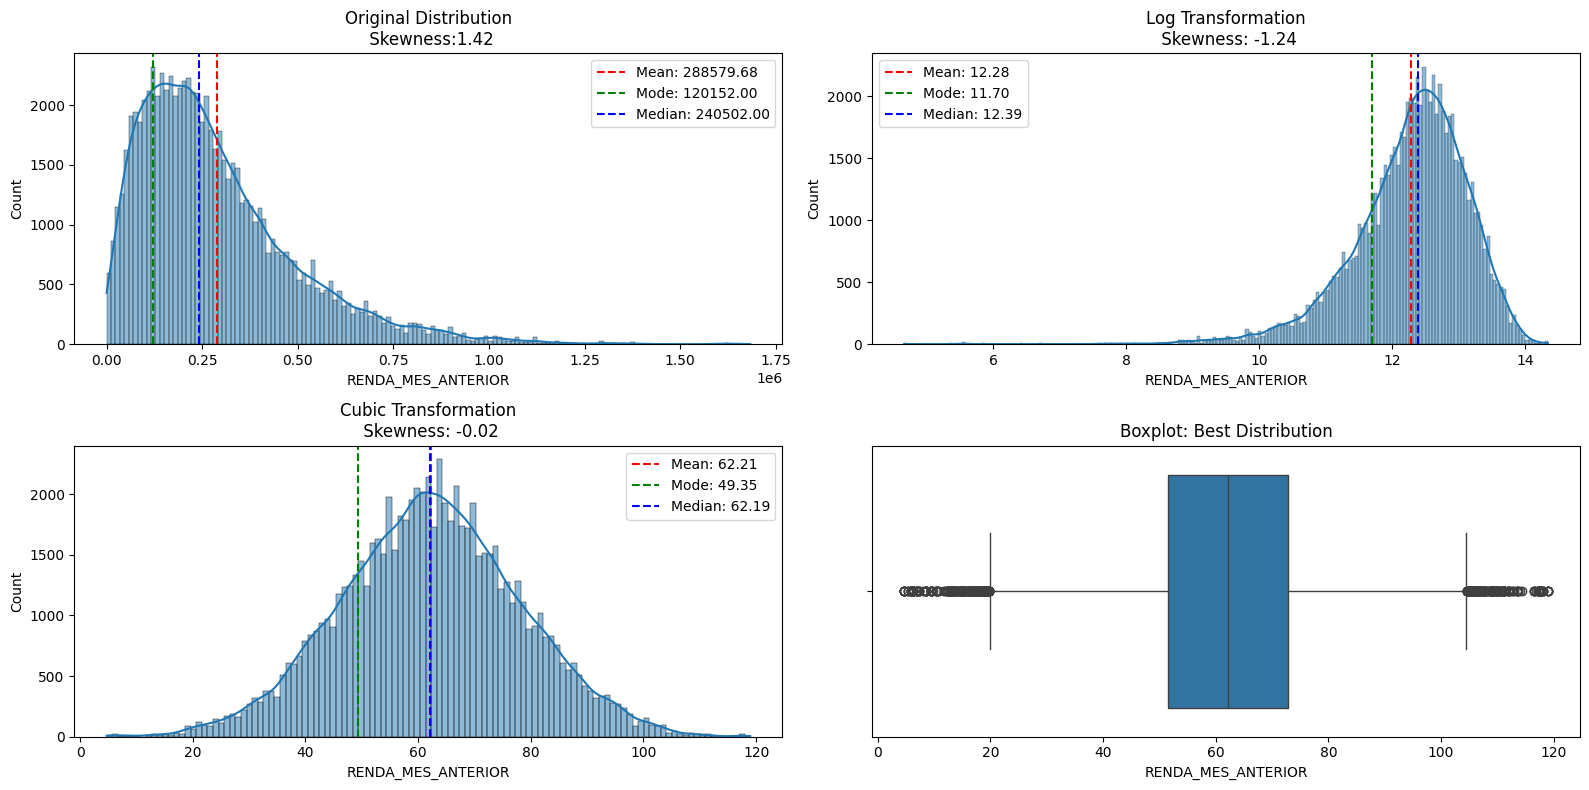

In [33]:
plotter.plot_transformed_distributions("RENDA_MES_ANTERIOR")

### For `RENDA_MES_ANTERIOR`, the **Cubic** transformation is the best one, and there are still outliers

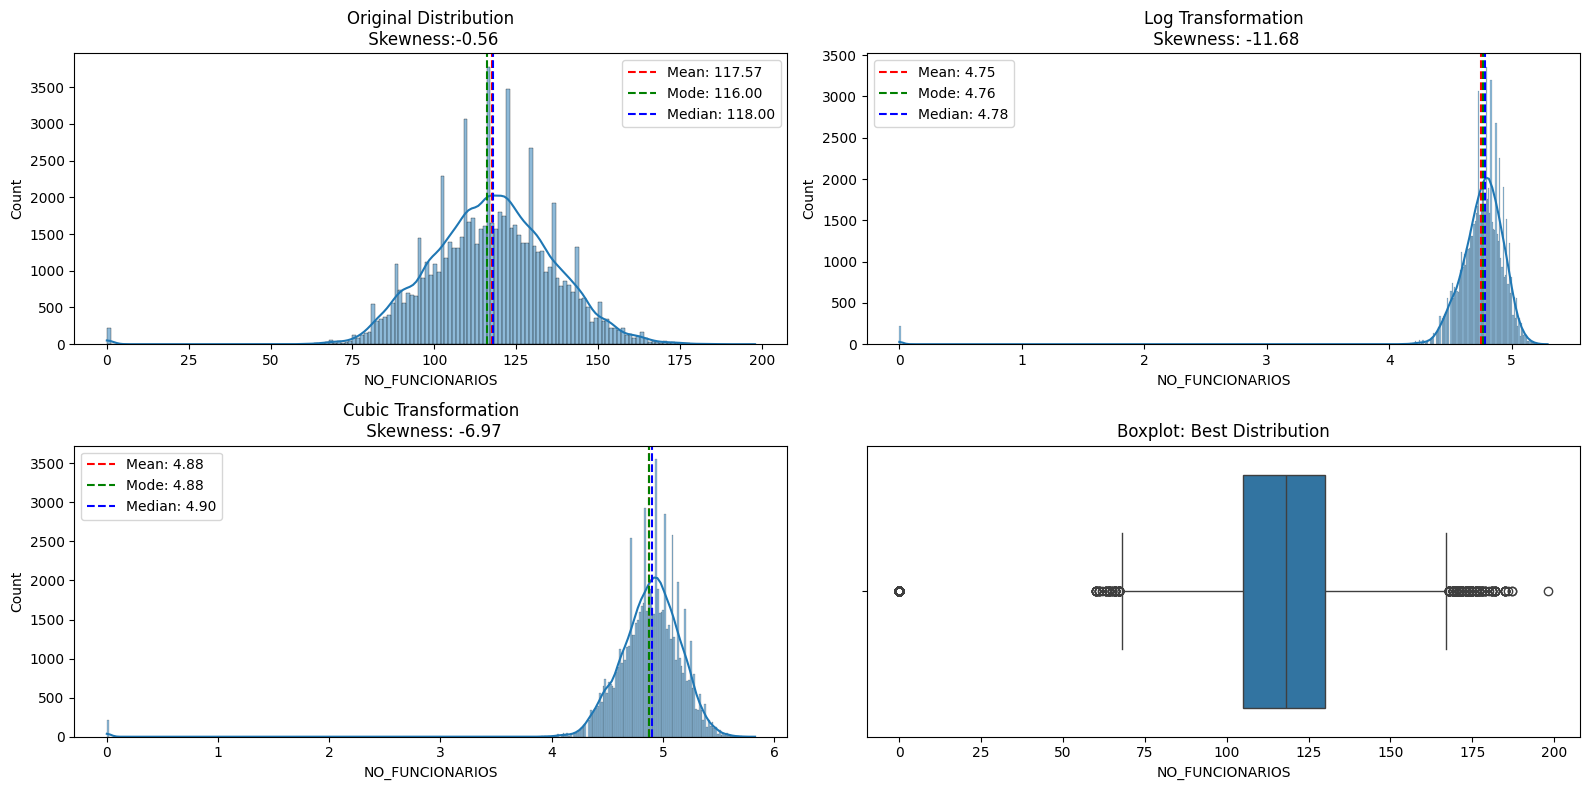

In [34]:
plotter.plot_transformed_distributions("NO_FUNCIONARIOS")

### For `NO_FUNCIONARIOS`, no transformation is needed

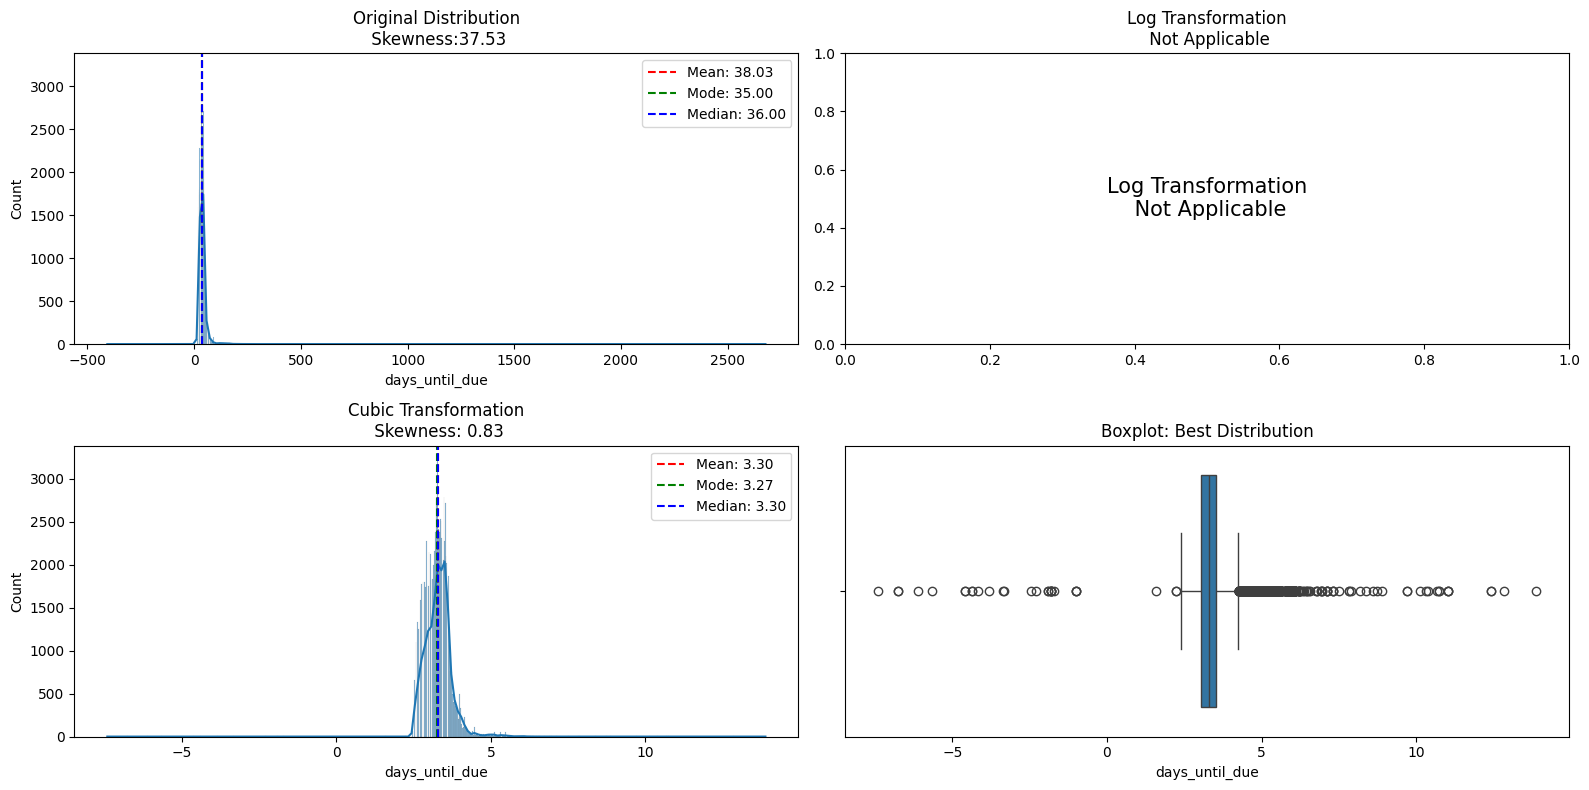

In [35]:
plotter.plot_transformed_distributions("days_until_due")

### For `days_until_due`, the **Cubic** transformation is the best one, and there are a lot of outliers

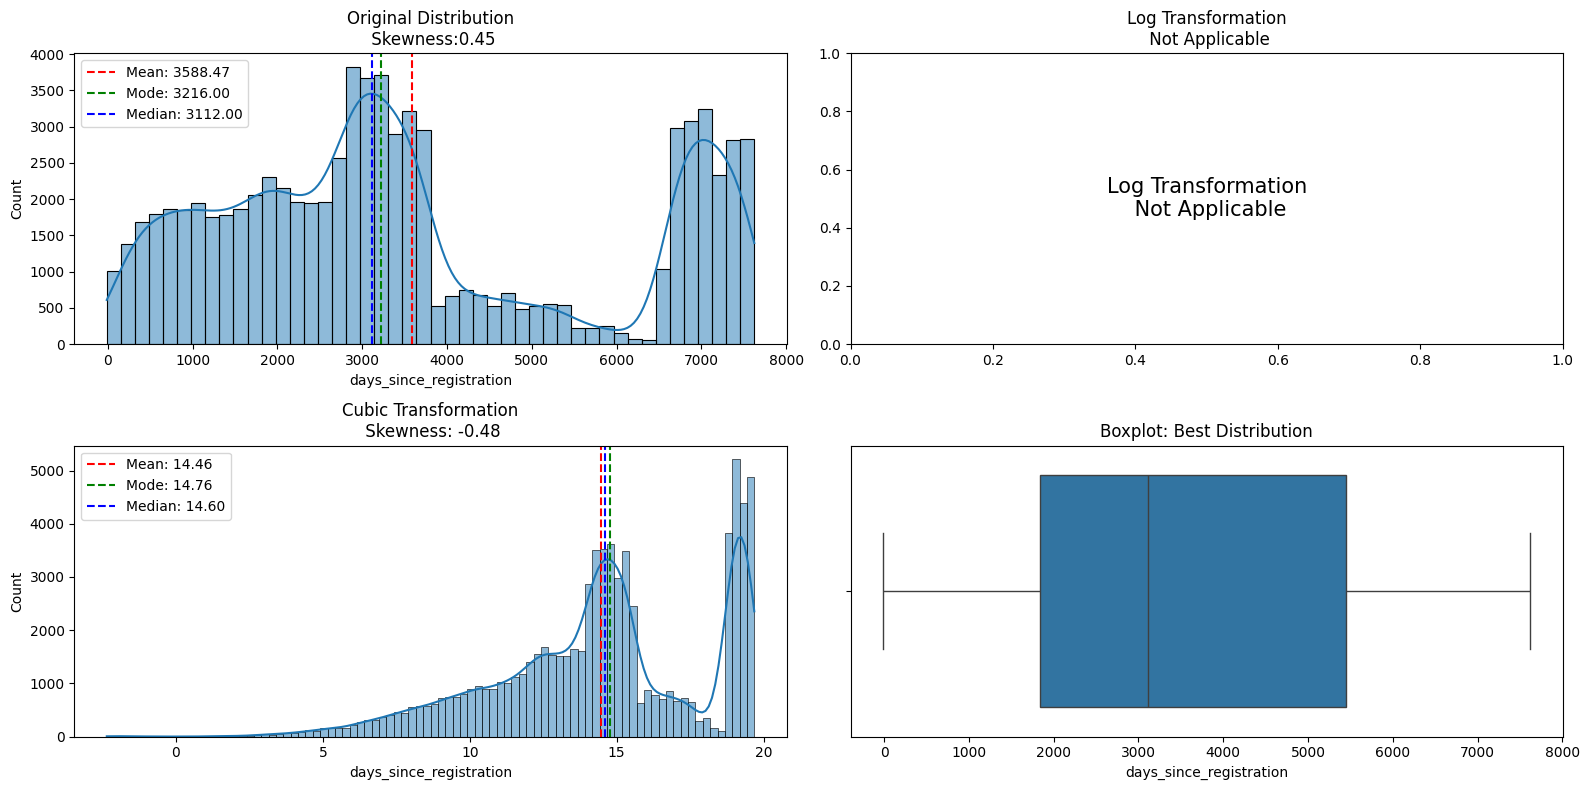

In [36]:
plotter.plot_transformed_distributions("days_since_registration")

### For `days_since_registration`, no transformation is needed

# Saving the file

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77414 entries, 0 to 77413
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   VALOR_A_PAGAR            77414 non-null  float64
 1   TAXA                     77414 non-null  float64
 2   DDD                      77414 non-null  object 
 3   SEGMENTO_INDUSTRIAL      77414 non-null  object 
 4   DOMINIO_EMAIL            77414 non-null  object 
 5   PORTE                    77414 non-null  object 
 6   CEP_2_DIG                77414 non-null  object 
 7   RENDA_MES_ANTERIOR       77414 non-null  float64
 8   NO_FUNCIONARIOS          77414 non-null  float64
 9   INADIMPLENTE             77414 non-null  int64  
 10  month_vencimento         77414 non-null  int32  
 11  days_until_due           77414 non-null  int64  
 12  days_since_registration  77414 non-null  int64  
dtypes: float64(4), int32(1), int64(3), object(5)
memory usage: 7.4+ MB


In [38]:
saving_dataset(df, "Data", "model_training_payments")